In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.gan import *

## LSun bedroom data

For this lesson, we'll be using the bedrooms from the [LSUN dataset](http://lsun.cs.princeton.edu/2017/). The full dataset is a bit too large so we'll use a sample from [kaggle](https://www.kaggle.com/jhoward/lsun_bedroom).

In [3]:
path = Path('data/lsun/bedroom')

We then grab all the images in the folder with the data block API. We don't create a validation set here for reasons we'll explain later.

We'll begin with a small side and use gradual resizing.

In [4]:
bs = 128
size = 32
train_ds = (GANItemList.from_folder(path).no_split().label_from_func(noop)
               .transform(tfms=([crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))],
                                []), 
                          size=size, tfm_y=True))

In [5]:
data = (ImageDataBunch.create(train_ds.train, valid_ds=train_ds.valid, path=path, bs=bs)
                     .normalize(do_x=False, stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_y=True))

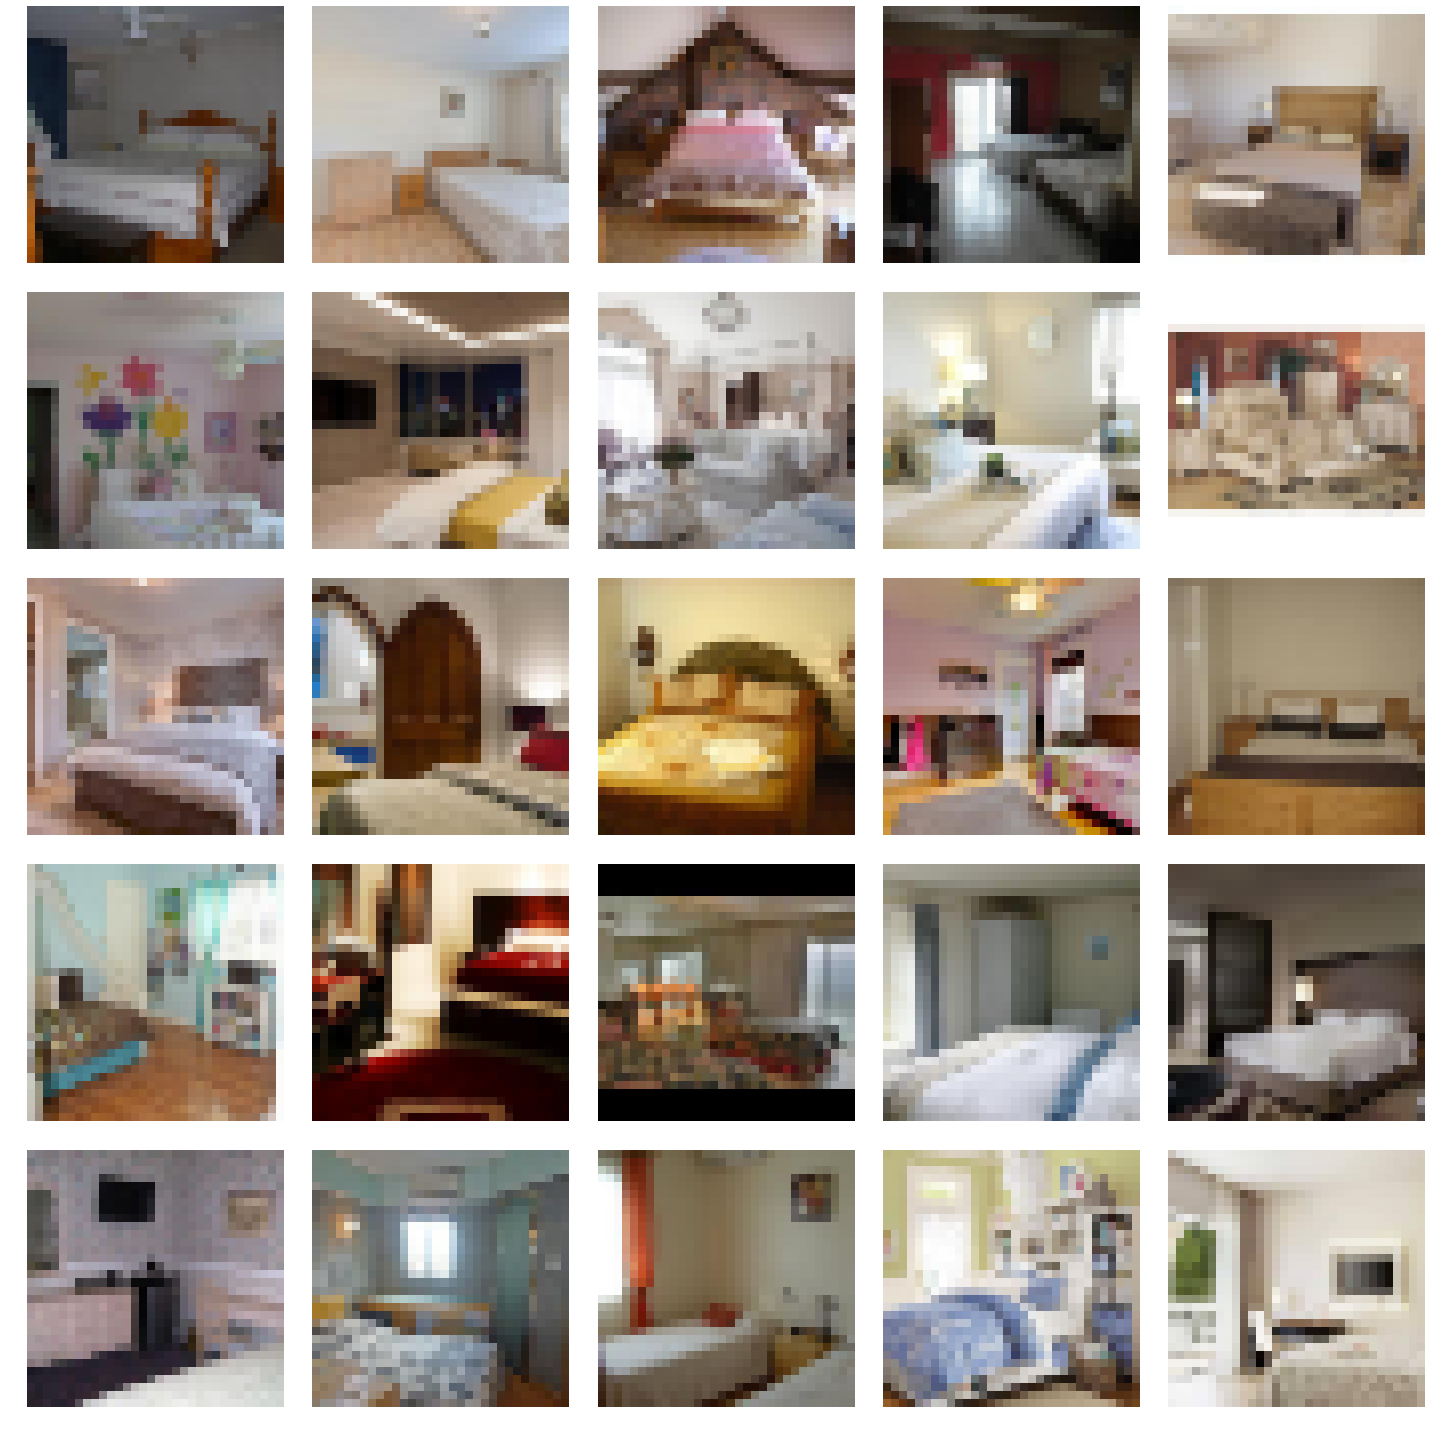

In [6]:
data.show_batch(rows=5)

In [7]:
ae_lls = (ImageItemList.from_folder(path).no_split().label_from_func(noop)
               .transform(tfms=([crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))],
                                [crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))]), 
                          size=size, tfm_y=True))

In [8]:
ae_data = (ImageDataBunch.create(ae_lls.train, valid_ds=ae_lls.valid, path=path, bs=bs)
                     .normalize(do_x=True, stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_y=False))

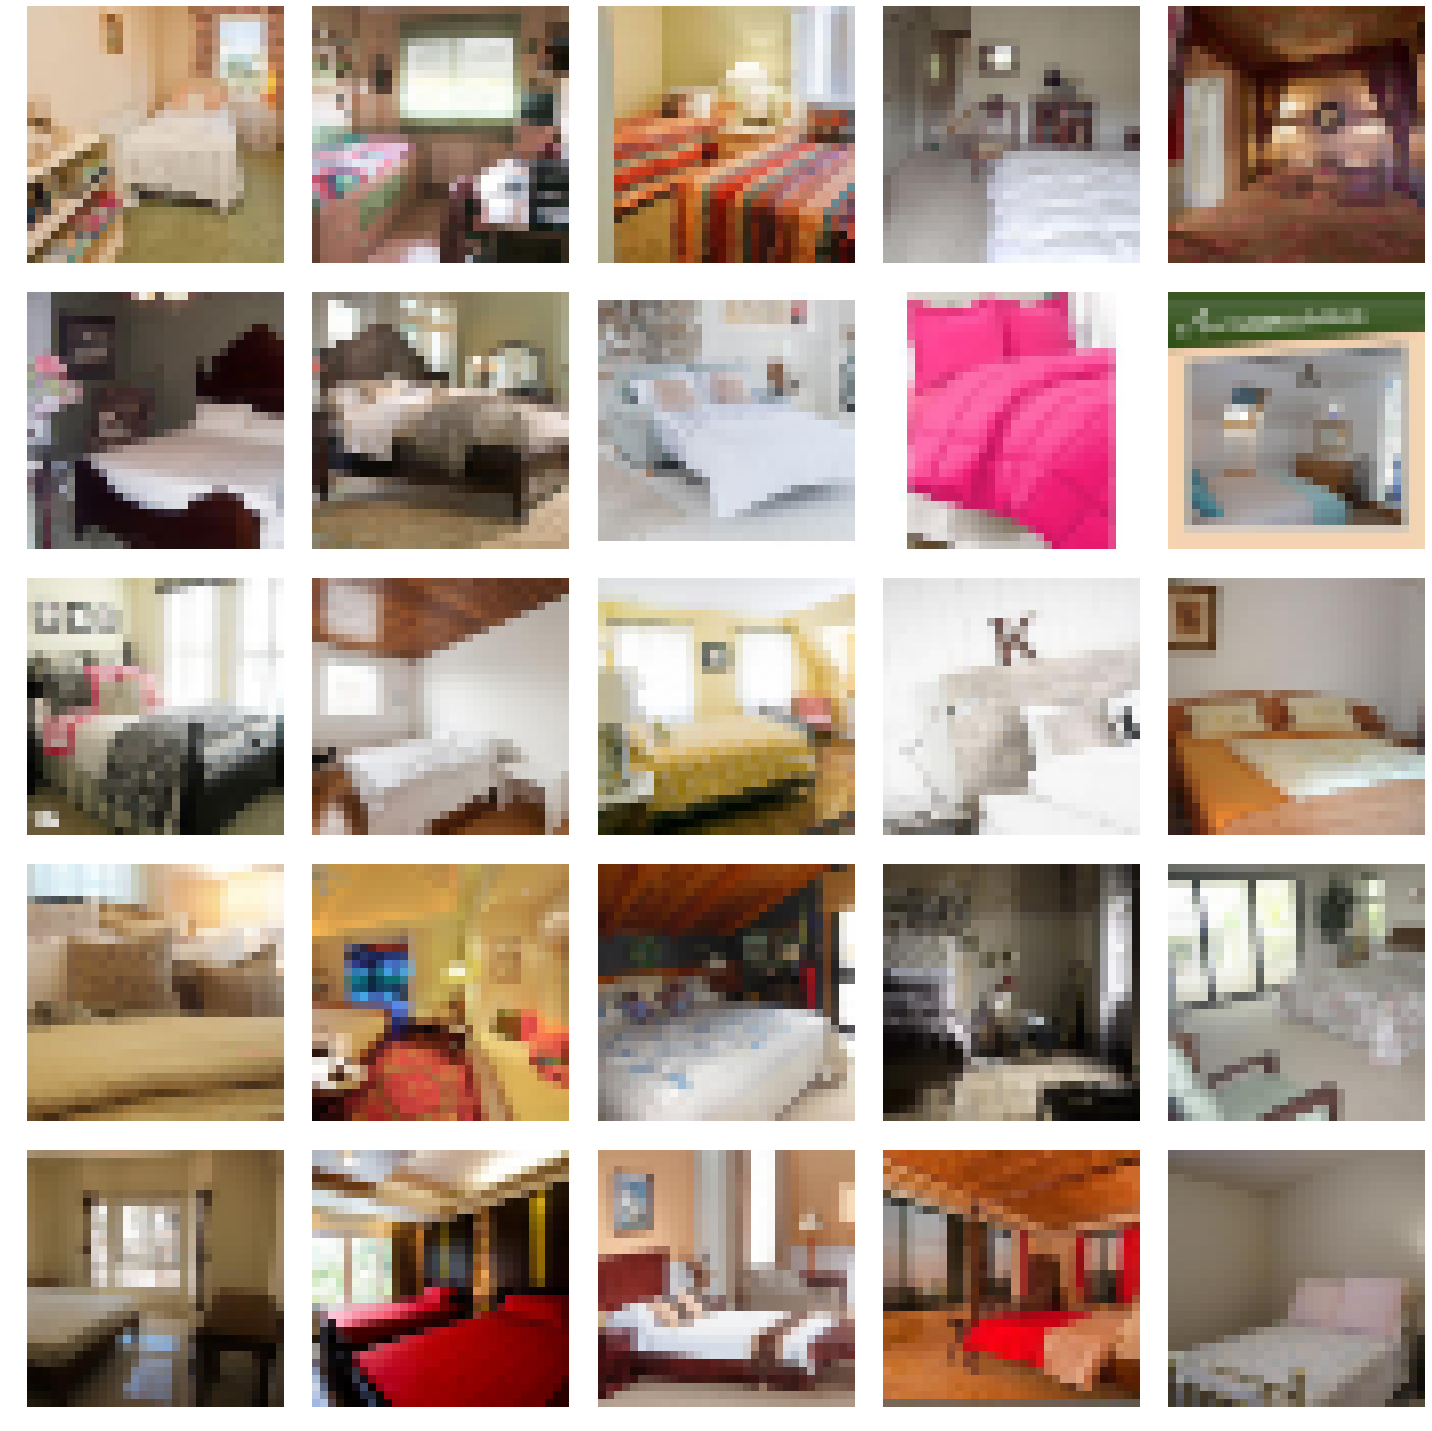

In [9]:
ae_data.show_batch(rows=5)

## Models

GAN stands for [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf) and were invented by Ian Goodfellow. The concept is that we will train two models at the same time: a generator and a discriminator. The generator will try to make new images similar to the ones in our dataset, and the discriminator job will try to classify real images from the ones the generator does. The generator returns images, the discriminator a single number (usually 0. for fake images and 1. for real ones).

We train them against each other in the sense that at each step (more or less), we:
1. Freeze the generator and train the discriminator for one step by:
  - getting one batch of true images (let's call that `real`)
  - generating one batch of fake images (let's call that `fake`)
  - have the discriminator evaluate each batch and compute a loss function from that; the important part is that it rewards positively the detection of real images and penalizes the fake ones
  - update the weights of the discriminator with the gradients of this loss
  
  
2. Freeze the discriminator and train the generator for one step by:
  - generating one batch of fake images
  - evaluate the discriminator on it
  - return a loss that rewards posisitivly the discriminator thinking those are real images; the important part is that it rewards positively the detection of real images and penalizes the fake ones
  - update the weights of the generator with the gradients of this loss
  
Here, we'll use the [Wassertein GAN](https://arxiv.org/pdf/1701.07875.pdf).

We create a generator and a discriminator that we pass to `gan_learner`. The noise_size is the size of the random vector from which our generator creates images.

In [10]:
generator = basic_generator(in_size=size, n_channels=3, n_extra_layers=1).cuda()
critic = basic_critic(in_size=size, n_channels=3, n_extra_layers=1).cuda()

In [11]:
x,y = next(iter(ae_data.train_dl))

## Autoencoder

In [12]:
nn.Sequential(*(list(critic.children())[:-2]+[]))(x).shape

torch.Size([128, 256, 4, 4])

In [13]:
in_channels = nn.Sequential(*(list(critic.children())[:-2]+[]))(x).shape[1]

In [14]:
in_channels

256

In [15]:
enc = nn.Sequential(*(list(critic.children())[:-2]+[nn.Conv2d(in_channels,100,4)])).cuda()

In [16]:
generator(enc(x)).shape

torch.Size([128, 3, 32, 32])

In [17]:
ae = nn.Sequential(enc,generator).cuda()

In [18]:
ae_learn = Learner(ae_data,ae,loss_func=F.mse_loss)

In [19]:
ae_learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


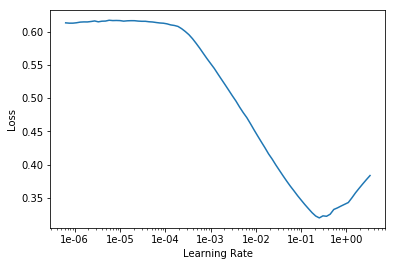

In [20]:
ae_learn.recorder.plot()

In [21]:
ae_learn.fit_one_cycle(1,1e-2)

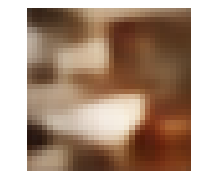

In [22]:
Image(ae(x)[3].data).show()

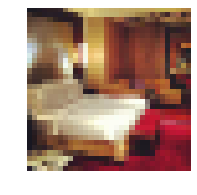

In [23]:
Image(y[3]).show()

## WGAN

In [24]:
# learn = GANLearner.wgan(data, generator, critic, opt_func=optim.RMSprop, wd=0.)
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

epoch,train_loss,gen_loss,disc_loss
1,-0.544556,0.339187,-0.715628
2,-0.312106,0.233772,-0.419367
3,-0.237367,0.181648,-0.326785
4,-0.198350,0.153572,-0.264942
5,-0.177202,0.140616,-0.240543
6,-0.160339,0.128411,-0.222938
7,-0.163764,0.129497,-0.218444
8,-0.150589,0.123421,-0.207393
9,-0.141368,0.121975,-0.199878
10,-0.141368,0.105186,-0.187074


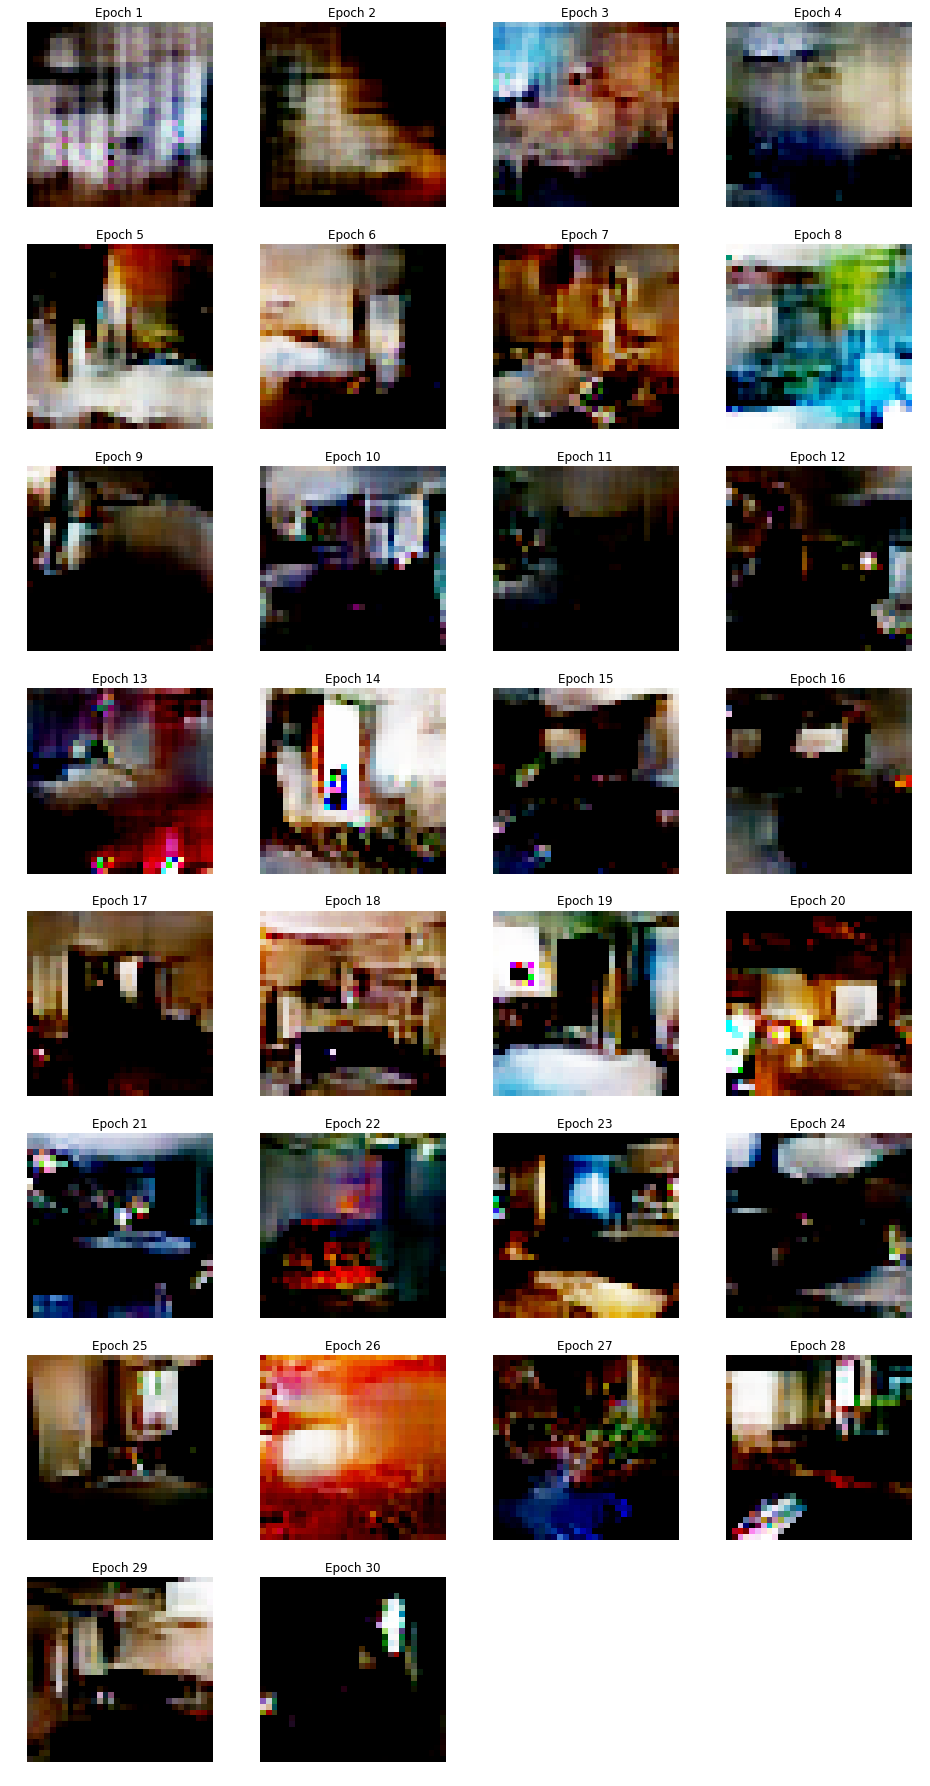

In [25]:
learn.fit(30,2e-4)

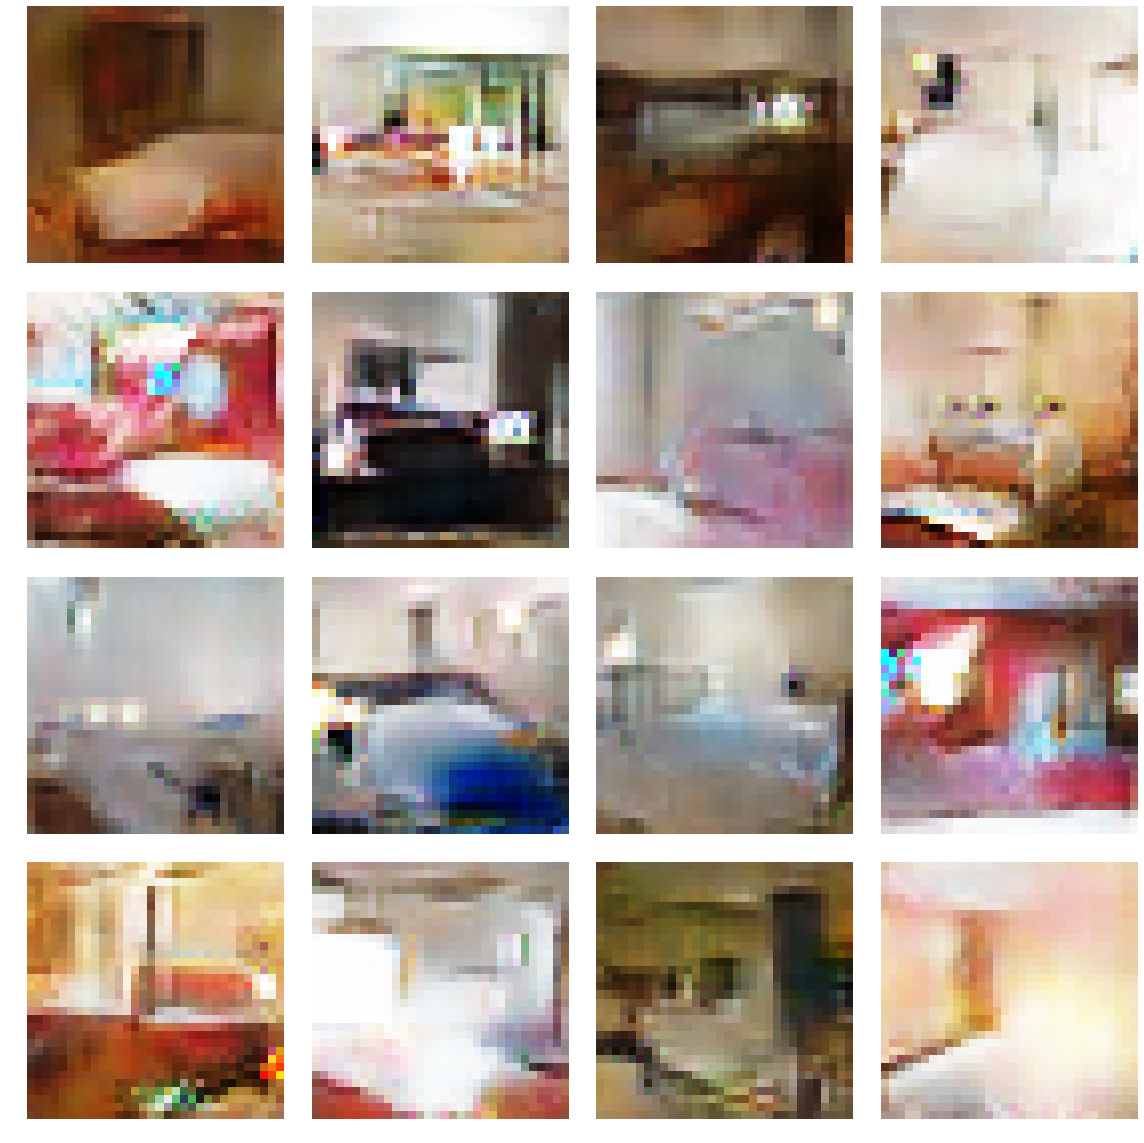

In [26]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(16,16))